# Notebook 1.C

## Generaization

Train/Validation/Test split

In [1]:
# import pytorch
import torch
from torch import nn
import numpy as np
# import from helpers
from helpers import f, obs, MSE
# use type indicators
from typing import Callable
# imports for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
# padas data frame
import pandas as pd
# deep copy for copying model
from copy import deepcopy
# sample random inetegers
import random

from helpers import Tracking # helps us tracking the model weights for visualizaiton!

# %matplotlib notebook

In [2]:
sns.set_theme()
sns.set_style("darkgrid")

Again, we will use the Implementation of our non linear model and our synthetic example.

In [3]:
class NonLinearModel(torch.nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 n_intermediate: int,
                 intermediate_dim: int, 
                 output_dim: int,
                 act_fun: nn.Module) -> None:
        super(NonLinearModel, self).__init__()
        
        # we will store all our layers/operations here
        self.layers = torch.nn.Sequential()
        
        if n_intermediate > 0:  
            # add input layer
            self.layers.append(nn.Linear(in_features=input_dim, 
                                         out_features=intermediate_dim))
        
            # add intermediate layers and activation functions
            for _ in range(n_intermediate-1):
                self.layers.append(act_fun)
                self.layers.append(nn.Linear(in_features=intermediate_dim, 
                                             out_features=intermediate_dim))
        
            # add  output layer
            self.layers.append(act_fun)
            self.layers.append(nn.Linear(in_features=intermediate_dim, 
                                         out_features=output_dim))
        else:
            self.layers.append(nn.Linear(in_features=input_dim, 
                                         out_features=output_dim))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # execute all operations
        out = self.layers(x)
        return out
    
    
def scale_data(x: torch.Tensor) -> torch.Tensor:
    xmin = x.min()
    xmax = x.max()
    delta = xmax - xmin
    scaled = 2*(x - xmin)/torch.clip(delta, min=1e-7) - 1
    return scaled
    

We will start with a train/test split and will check if the evaluation on the test split resamples the error w.r.t the true function

NonLinearModel(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)


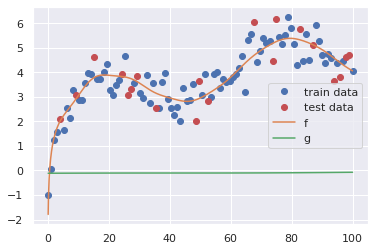

In [4]:
# Let's instantiate the new model function
net = NonLinearModel(input_dim=1,
                     n_intermediate=3, # number of hidden leayers
                     intermediate_dim=10, # number of neurons per hidden layer 
                     output_dim=1,
                     act_fun=torch.nn.Tanh()) # let us start with sigmoid activation
print(net)

# and lets apply the function on our data and plot it
N_datapoints = 100
x_data = torch.linspace(0.1,100,N_datapoints)
y_data = obs(x_data)

# sample train and test split
idx_test = random.sample(range(N_datapoints), 20)
idx_train = [i for i in range(N_datapoints) if i not in idx_test]

x = x_data[idx_train]
y = y_data[idx_train]

x_test = x_data[idx_test]
y_test = y_data[idx_test]

x_scaled = scale_data(x)
out = net(x_scaled.view(-1,1))

interval = torch.linspace(0.1,100,1000)
fx = f(interval) 
plt.close()
plt.plot(x, y, 'o', label='train data')
plt.plot(x_test, y_test, 'ro', label='test data')
plt.plot(interval, fx, label='f')
plt.plot(x, out.detach().squeeze(), label='g')
plt.legend()
plt.show()

In [5]:
# get weight tracker
tracker = Tracking()

optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
n_epoch = 20000
loss_array = []
fx_diff = []
fx_epoch = []
loss_test = []
track_every = 500
for epoch in range(n_epoch):
    # track current weight
    if epoch % track_every == 0:
        print(epoch)
        tracker.update(epoch=epoch, net=net)
    
    # set all gradients to zero
    net.zero_grad()
    
    # apply neural network on all data points
    out = net(x_scaled.view(-1,1))
    
    # calculate loss
    loss = MSE(y=y, gx=out.view(-1))
    
    # calculate gradients
    loss.backward()
    
    # one step along the steppest descent
    optimizer.step()
    
    
    # apply model on interval to calc diff to f
    if epoch % track_every == 0:
         # store loss vor visualization
        loss_array.append(loss.item())
        # apply model on interval to calc diff to f and test loss
        with torch.no_grad():
            # track test error
            out_test = net(scale_data(x_test).view(-1,1))
            loss_test.append(MSE(y=y_test, gx=out_test.view(-1)))
            # track diff to f
            interval_scaled = scale_data(interval)
            out_f = net(interval.view(-1,1))
            diff = ((out_f.view(-1) - fx.view(-1)).abs()).mean()
            fx_diff.append(diff.item())
            fx_epoch.append(epoch)
    if epoch % track_every == 0:
        print(f'\r[{epoch}/{n_epoch}]: loss = {loss}', end="")

0
[0/20000]: loss = 16.441625595092773500
[500/20000]: loss = 0.81338703632354741000
[1000/20000]: loss = 0.69937819242477421500
[1500/20000]: loss = 0.336262464523315432000
[2000/20000]: loss = 0.27878382802009582500
[2500/20000]: loss = 0.256658256053924563000
[3000/20000]: loss = 0.237531587481498723500
[3500/20000]: loss = 0.228152841329574584000
[4000/20000]: loss = 0.22470334172248844500
[4500/20000]: loss = 0.22253128886222845000
[5000/20000]: loss = 0.220687419176101685500
[5500/20000]: loss = 0.21872262656688696000
[6000/20000]: loss = 0.215982466936111456500
[6500/20000]: loss = 0.207186102867126467000
[7000/20000]: loss = 0.19689163565635687500
[7500/20000]: loss = 0.192620337009429938000
[8000/20000]: loss = 0.190213561058044438500
[8500/20000]: loss = 0.188665404915809639000
[9000/20000]: loss = 0.186663359403610239500
[9500/20000]: loss = 0.1835815608501434310000
[10000/20000]: loss = 0.1806879490613937410500
[10500/20000]: loss = 0.177484422922134411000
[11000/20000]: lo

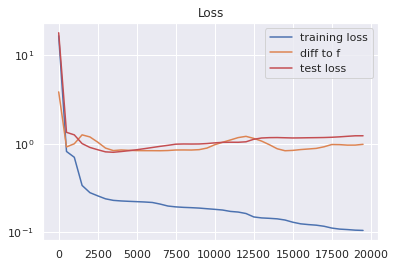

In [6]:
plt.close()    
plt.yscale('log')
plt.title('Loss')
plt.plot(fx_epoch, loss_array, label='training loss')
plt.plot(fx_epoch, fx_diff, label='diff to f')
plt.plot(fx_epoch, loss_test, 'r', label='test loss')
plt.legend()
plt.show()
#plt.savefig('/home/hubert/Lecture/Resources/overfitting.svg')

 plotting epoch 39

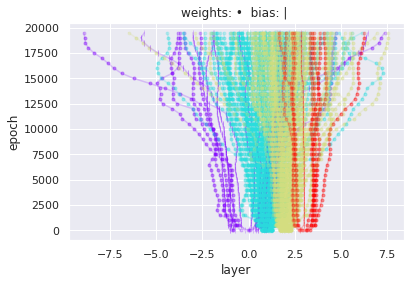

In [7]:
plt.close()
tracker.plot(alpha=0.2, 
             overlay=False, 
             params=['weight', 'bias'],
             save_at='/tmp/weight_change_overfitting.png')

 plotting epoch 39

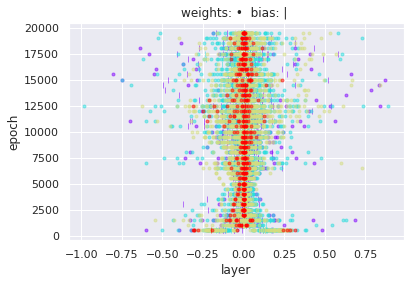

In [8]:
plt.close()
tracker.plot_diff(alpha=0.5, overlay=True, params=['bias', 'weight'])

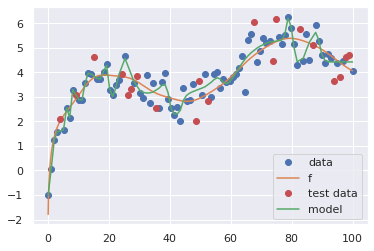

In [9]:
out = net(x_scaled.view(-1,1))

plt.close()
plt.plot(x, y, 'o', label='data')
plt.plot(interval, fx, label='f')
plt.plot(x_test, y_test, 'ro', label='test data')
plt.plot(x, out.detach().squeeze(), label='model')
plt.legend()
# plt.show()
plt.savefig('/tmp/test_set_overfitting.svg')

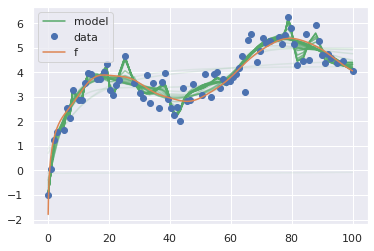

In [10]:
plt.close()
tracker.plot_models(x, y, 
                    interval, fx, 
                    net, 
                    x_model=x_scaled, 
                    color='g', 
                    alpha_scaling=0.8,
                    save_at='/tmp/test_set_overfitting_history.svg')

Lets try out the new model with different settings - play around with the parameters!

0,1,... intermediate layers
nn.Sigmoid(), nn.Tanh() and nn.ReLu() activation functions
adapt the learning rate if necessary!
adapt the number of iterations if necessary!
what do you observe?

# Maximum Likelihood

In [14]:
# log likelihood

def normal_log_likelihood( data: torch.Tensor, mean: float, sigma: float) -> torch.Tensor:
    assert len(data.shape) == 1
    c1 = -np.log(np.sqrt(2*np.pi*sigma**2))
    c2 = - 1./(2*sigma**2 + 1e-12) * ((data - mean)**2).sum()
    return c1 + c2

In [16]:
data  = torch.randn(100) + 5

In [18]:
means = np.linspace(0, 10, 50)
out = []
for m in means:
    nll = normal_log_likelihood(data, m, 1.)
    out.append(nll)

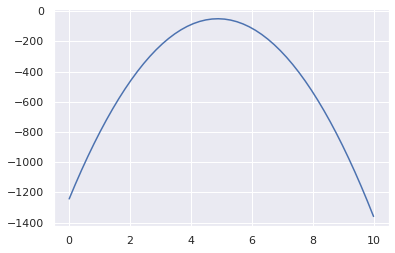

In [19]:
plt.plot(means, out)